In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

   PERMNO      date      PRC       RET     SHROUT  year
0   10001  20020131  11.3000 -0.013100  2566000.0  2002
1   10001  20020228  10.7000 -0.053097  2569000.0  2002
2   10001  20020328  10.4000 -0.015888  2571000.0  2002
3   10001  20020430   9.9500 -0.043269  2571000.0  2002
4   10001  20020531  10.0975  0.014824  2571000.0  2002
10674
             PERMNO          date            PRC            RET        SHROUT  \
count  1.005040e+06  1.005040e+06  998010.000000  992894.000000  1.004039e+06   
mean   6.397102e+04  2.010890e+07      71.005103       0.011047  1.124898e+08   
std    2.999603e+04  5.874322e+04    3105.532997       0.183513  4.416489e+08   
min    1.000100e+04  2.002013e+07       0.010500      -0.993600  9.000000e+03   
25%    3.298600e+04  2.006023e+07       5.800000      -0.062370  1.337500e+07   
50%    7.973100e+04  2.010113e+07      15.650000       0.003856  3.152100e+07   
75%    8.761200e+04  2.016053e+07      32.820000       0.069640  7.432000e+07   
max    9.3

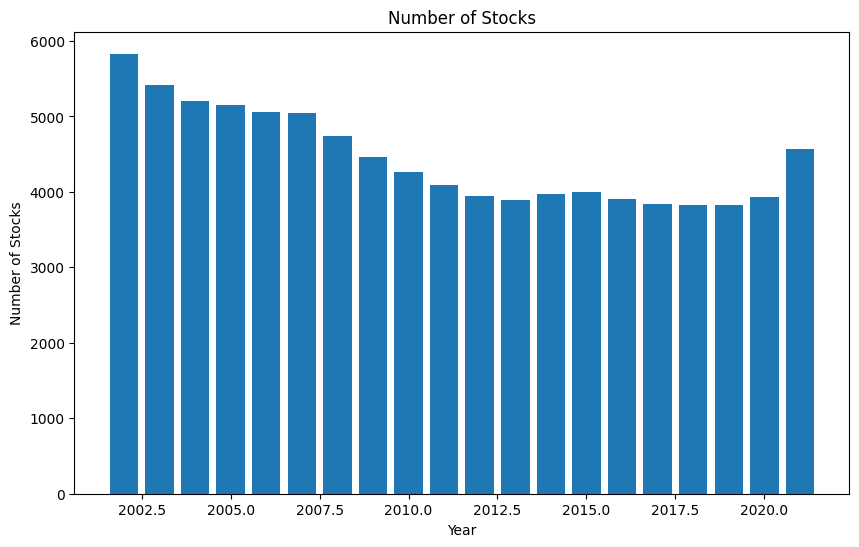

In [6]:
# Load and prepare data
factordata = pd.read_csv("factorinvestingdata.csv")
factordata = factordata.iloc[:, 1:]  # Remove the first column
print(factordata.head())
print(len(factordata['PERMNO'].unique()))  # Number of stocks
print(factordata.describe())
print("Total rows", f"{len(factordata['PERMNO']):,.0f}")  # Number of rows

# Number of stocks each month
factordata['year'] = factordata['date'].astype(str).str[:4].astype(int)
stockno = factordata.groupby('year')['PERMNO'].nunique().reset_index(name='stockno')

plt.figure(figsize=(10, 6))
plt.bar(stockno['year'], stockno['stockno'])
plt.title("Number of Stocks")
plt.xlabel("Year")
plt.ylabel("Number of Stocks")
plt.show()

In [ ]:
# Constructing factor signals
factordata = factordata.dropna(subset=['RET'])
factordata['mktcap'] = factordata['PRC'] * factordata['SHROUT']
factordata = factordata.sort_values(['PERMNO', 'date'])

def rolling_prod(x, window):
    return x.rolling(window=window, min_periods=1).apply(lambda x: np.prod(1 + x) - 1)

factordata['pastreturn'] = factordata.groupby('PERMNO')['RET'].transform(lambda x: rolling_prod(x, 11))
factordata['lmktcap'] = factordata.groupby('PERMNO')['mktcap'].shift(1)
factordata['lpastreturn'] = factordata.groupby('PERMNO')['pastreturn'].shift(1)
factordata['lprice'] = factordata.groupby('PERMNO')['PRC'].shift(1)

factordata['retrank'] = factordata.groupby('date')['lpastreturn'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
factordata['sizerank'] = factordata.groupby('date')['lmktcap'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)

print(factordata[['PERMNO', 'date', 'RET', 'lpastreturn', 'lmktcap', 'retrank', 'sizerank']].head(10))

# Calculating factor returns
def factor_returns(group):
    return pd.Series({
        'Large': group[group['sizerank'] == 10]['RET'].mean(),
        'Small': group[group['sizerank'] == 1]['RET'].mean(),
        'Winner': group[(group['retrank'] == 10) & (group['lprice'] >= 2)]['RET'].mean(),
        'Loser': group[(group['retrank'] == 1) & (group['lprice'] >= 2)]['RET'].mean(),
        'Market': group['RET'].mean()
    })

factorreturn = factordata.groupby('date').apply(factor_returns).reset_index()
factorreturn['Size'] = factorreturn['Small'] - factorreturn['Large']
factorreturn['Momentum'] = factorreturn['Winner'] - factorreturn['Loser']

longformat = pd.melt(factorreturn, id_vars=['date'], var_name='Factors', value_name='value')
factorperformance = longformat.groupby('Factors').agg({
    'value': ['mean', 'std']
}).reset_index()
factorperformance.columns = ['Factors', 'Mean', 'Volatility']
factorperformance['T_stat'] = factorperformance.apply(lambda row: stats.ttest_1samp(longformat[longformat['Factors'] == row['Factors']]['value'].dropna(), 0)[0], axis=1)

print(factorperformance.head(7))

# Cumulative factor performance over time
factorreturn['date'] = pd.to_datetime(factorreturn['date'], format='%Y%m%d')
xtsdata = factorreturn.set_index('date')
xtsdata['Momentum'] = (1 + xtsdata['Momentum']).cumprod()
xtsdata['Size'] = (1 + xtsdata['Size']).cumprod()
xtsdata['Market'] = (1 + xtsdata['Market']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(xtsdata.index, xtsdata['Momentum'], label='Momentum')
plt.plot(xtsdata.index, xtsdata['Market'], label='Market')
plt.title("Momentum vs. Market")
plt.ylabel("Dollar Investment Return")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(xtsdata.index, xtsdata['Size'], label='Size')
plt.plot(xtsdata.index, xtsdata['Market'], label='Market')
plt.title("Size vs. Market")
plt.ylabel("Dollar Investment Return")
plt.legend()
plt.show()